Metrics

In [1]:
# import geopandas as gpd
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
def L2Norm(obs): #L2 Norm
    obs = np.array(obs)
    #calculate the L2 norm
    L2norm = np.sqrt(np.sum(obs**2))
    return round(L2norm, 3)

def Gfit(obs, pred, t = 0.1): #a normalized least-squares using threshold t
    obs = np.array(obs)
    pred = np.array(pred)
    #set values below threshold to 0
    obs[obs < t] = 0
    pred[pred < t] = 0
    #calculate the G value
    Gvalue = 1 - (2*np.sum(obs*pred)/(np.sum(obs**2)+np.sum(pred**2)))
    return round(Gvalue,3)

def AQC(obs, pred,t = 0.1): #Accuracy score based on threshold t
    obs = np.array(obs)
    pred = np.array(pred)
    # #plot histogram of the data
    # plt.hist(obs, bins = 100, alpha = 0.5, label = 'obs')
    # plt.hist(pred, bins = 100, alpha = 0.5, label = 'pred')
    # plt.legend(loc = 'upper right')
    # plt.show()

    #set values below threshold to 0
    obs[obs == t] = -99
    pred[pred == t] = -99
    #set values above threshold to 1
    obs[obs != -99] = 99
    pred[pred != -99] = 99

    #calculate the accuracy value
    aqc = np.sum(obs == pred)/len(obs)
    # print(t)
    # print(np.sum(obs == pred))
    # print(len(obs))
    # np.savetxt('obs.txt', obs)
    # np.savetxt('pred.txt', pred)
    #return value at 3 decimal place format
    return round(aqc, 3)

def Rsquared(obs, pred): #R-squared value
    obs = np.array(obs)
    pred = np.array(pred)
    #calculate the R-squared value
    Rsquared = 1 - (np.sum((obs - pred)**2)/np.sum((obs - np.mean(obs))**2))
    return round(Rsquared, 3)

def MSE(obs, pred): #Mean Squared Error
    obs = np.array(obs)
    pred = np.array(pred)
    #calculate the mean squared error
    mse = np.mean((obs - pred)**2)
    return round(mse, 3)


Historic Events

In [ ]:
import numpy as np
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt


g_list = ['1GaugeRiku', '3GaugeIshi', '3GaugeShio']
region_list = [3,2,1]
site_list = ['Rikuzentakata', 'Ishinomaki', 'Sendai']
epoch = 0
fold = [0,1,2,3,4]

fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
fig.suptitle('Accuracy of the model for different depth bins', fontsize=16)

#prepare empty pd dataframe to store the results Site, Event, G, Rsquared, MSE
results = pd.DataFrame(columns = ['Site', 'Event', 'G', 'Rsquared', 'MSE'])

for s in range(3):
    gauge = g_list[s]
    region = region_list[s]
    site = site_list[s]
    # print('Site; {}'.format(site))
    col_name_list = ['Lon', 'Lat', 'Ele', 'FUJI2011_42', 'NANKAI2022', 'SANRIKU1896', 'SANRIKU1933', 'TOKACHI1968', 'YAMAZAKI2018_TPMOD',
                        'SatakeMiniLowerSoft', 'SatakeMiniUpper', 'SatakeMiniUpperSoft', 'SatakeMiniLower']
            
    his_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{gauge}/_data/fgmax{region:04d}_hisflooded.csv'
    his_data = pd.read_csv(his_path, names=col_name_list)
    # print('his_data size is {}'.format(his_data.shape))

    hist_name_list = ['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']   
    neve = len(hist_name_list)
    # print('Events plotting are {}'.format(hist_name_list))

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    ls=['-','--',':','-','--',':']

    # Plot each event
    for i in range(neve):  

        # Get data for the event
        event = hist_name_list[i]
        # print('event is {}'.format(event))
        for f in fold:
            predict_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{gauge}/_output/vae_riku_test_{event}_k{f}_e{epoch:04d}.npy'
            predict_fold = np.load(predict_path)
            if f == 0:
                predict = predict_fold
            else:
                predict = np.append(predict,predict_fold,axis=0)
        
        #Bin classes
        thresholds = [0.1,1,2,5,10,15]
        label = ['0.1m-1m','1m-2m','2m-5m','5m-10m','10m-15m','15m+']

        # thresholds = np.arange(0.1,16,1)
        # label = ['0.1m','1m','2m','3m','4m','5m','6m','7m','8m','9m','10m','11m','12m','13m','14m','15m']

        eve_data = his_data[hist_name_list[i]].squeeze()
        mean = np.mean(predict, axis=0).squeeze()  

        #classify the data and mean prediction using the thresholds
        obs = np.zeros(eve_data.shape) #all are 0
        mean_pred = np.zeros(eve_data.shape)
        
        #calculate G,Rsquared and MSE for the mean prediction
        Geve = Gfit(eve_data,mean)
        Rsquaredeve = Rsquared(eve_data,mean)
        MSEeve = MSE(eve_data,mean)
        L2Normeve = L2Norm(eve_data)

        #store the results
        results = results.append({'Site':site, 'Event':event, 'G':Geve, 'Rsquared':Rsquaredeve, 'MSE':MSEeve, 'L2Norm':L2Normeve}, ignore_index=True)
        # print('For site {}; event {}; G is {}; Rsquared is {}; MSE is {};L2Norm is {}'.format(site,event,Geve,Rsquaredeve,MSEeve,L2Normeve))

        #classify 
        for j in range(len(thresholds)):
            obs[(eve_data >= thresholds[j])] = j #replace with the class threshold
            mean_pred[(mean >= thresholds[j])] = j

        TPR_mean = np.zeros(len(thresholds))
        FPR_mean = np.zeros(len(thresholds)) 
        AQC_mean = np.zeros(len(thresholds))
        G_mean = np.zeros(len(thresholds))

        for j in range(len(thresholds)):
            TPR_mean[j] = np.sum((obs == j) & (mean_pred == j))/np.sum(obs == j)
            FPR_mean[j] = np.sum((obs != j) & (mean_pred == j))/np.sum(obs != j)
            AQC_mean[j] = AQC(obs,mean_pred,j)

            #get data of the depth bins
            ob = eve_data[obs ==j]
            prd = mean[obs == j]
            G_mean[j] = Gfit(ob,prd)
        
        # print('TPR_mean is {}'.format(TPR_mean))
        # print('FPR_mean is {}'.format(FPR_mean))
        # print('AQC_mean is {}'.format(AQC_mean))
        # #count in each class
        # print('obs is {}'.format(np.unique(obs, return_counts=True)))
        # print('mean_pred is {}'.format(np.unique(mean_pred, return_counts=True)))

        #classify each realisation of prediction
        for realisation in range(predict.shape[0]):  #for each one of 100 realisations

            #classify the data and the prediction for the AOC using the thresholds
            obs = np.zeros(eve_data.shape) #all are 0
            pred = np.zeros(eve_data.shape)

            #relabel the data and the prediction
            for j in range(len(thresholds)):
                obs[(eve_data >= thresholds[j])] = j #replace with the class threshold
                pred[(predict[realisation] >= thresholds[j])] = j
            
            #calculate the TPR and FPR
            TPR = np.zeros(len(thresholds))
            FPR = np.zeros(len(thresholds))
            AQCr = np.zeros(len(thresholds))
            Gr = np.zeros(len(thresholds))
            
            for j in range(len(thresholds)):
                TPR[j] = np.sum((obs == j) & (pred == j))/np.sum(obs == j)
                FPR[j] = np.sum((obs != j) & (pred == j))/np.sum(obs != j)
                AQCr[j] = AQC(obs,pred,j)     

                ob = eve_data[obs == j]
                prd = predict[realisation][obs == j]
                Gr[j] = Gfit(ob,prd)
                
            # plot the Accuracy for each realisation
            ax[s].plot(label,AQCr,color = colors[i], alpha = 0.05,linewidth=0.3)

        ax[s].plot(label,AQC_mean, label = f'{event}', color = colors[i], linestyle = ls[i], alpha = 0.5,linewidth=1.5)
        ax[s].spines['top'].set_visible(False)
        ax[s].spines['right'].set_visible(False)
        ax[s].spines['bottom'].set_visible(False)
        ax[s].spines['left'].set_visible(True)
        ax[s].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        ax[s].set_title(' {}'.format(site), fontsize=12)
    ax[0].set_yticks(np.arange(0,1.1,0.1))
    ax[1].set_yticks(np.arange(0,1.2,0.2))
    ax[2].set_yticks(np.arange(0,1.2,0.2))
    ax[0].set_ylim(0.5,1.05)
    ax[1].set_ylim(0.5,1.05)
    ax[2].set_ylim(0.5,1.05)
    ax[2].set_xlabel('Depth bins')
    ax[1].set_ylabel('Accuracy')
    ax[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax[2].spines['bottom'].set_visible(True)
    ax[1].legend(ncol = 2, fontsize = 8)

plt.tight_layout()
plt.show()
# fig.savefig(f'/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/AQC_hist_depths_k{fold}_e{epoch:04d}.png', dpi=300, bbox_inches='tight')
results.to_csv(f'/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_depths_all.csv', index=False)

In [ ]:
#create a dataframe to store the results per region, depth and accuracy
results_per_region = pd.DataFrame(columns = ['Site', 'Event', 'Depth', 'Accuracy'])

g_list = ['1GaugeRiku', '3GaugeIshi', '3GaugeShio']
region_list = [3,2,1]
site_list = ['Rikuzentakata', 'Ishinomaki', 'Sendai']
epoch = 0
fold = [0,1,2,3,4]


for s in range(3):

    gauge = g_list[s]
    region = region_list[s]
    site = site_list[s]
    print('Site; {}'.format(site))
    col_name_list = ['Lon', 'Lat', 'Ele', 'FUJI2011_42', 'NANKAI2022', 'SANRIKU1896', 'SANRIKU1933', 'TOKACHI1968', 'YAMAZAKI2018_TPMOD',
                        'SatakeMiniLowerSoft', 'SatakeMiniUpper', 'SatakeMiniUpperSoft', 'SatakeMiniLower']
            
    his_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{gauge}/_data/fgmax{region:04d}_hisflooded.csv'
    his_data = pd.read_csv(his_path, names=col_name_list)
    print('his_data size is {}'.format(his_data.shape))

    hist_name_list = ['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']   
    neve = len(hist_name_list)
    print('Events plotting are {}'.format(hist_name_list))

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']
    ls=['-','--',':','-','--',':']

    # Plot each event
    for i in range(neve):  

        # Get data for the event
        event = hist_name_list[i]
        print('event is {}'.format(event))
        for f in fold:
            predict_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{gauge}/_output/vae_riku_test_{event}_k{f}_e{epoch:04d}.npy'
            predict_fold = np.load(predict_path)
            if f == 0:
                predict = predict_fold
            else:
                predict = np.append(predict,predict_fold,axis=0)
        
        #Bin classes
        thresholds = [0.1,1,2,5,10,15]
        label = ['0.1m-1m','1m-2m','2m-5m','5m-10m','10m-15m','15m+']

        # thresholds = np.arange(0.1,16,1)
        # label = ['0.1m','1m','2m','3m','4m','5m','6m','7m','8m','9m','10m','11m','12m','13m','14m','15m']

        eve_data = his_data[hist_name_list[i]].squeeze()
        mean = np.mean(predict, axis=0).squeeze()

        #classify the data and mean prediction using the thresholds
        obs = np.zeros(eve_data.shape)
        mean_pred = np.zeros(eve_data.shape)

        #classify
        for j in range(len(thresholds)):
            obs[(eve_data >= thresholds[j])] = j
            mean_pred[(mean >= thresholds[j])] = j

        TPR_mean = np.zeros(len(thresholds))
        FPR_mean = np.zeros(len(thresholds))
        AQC_mean = np.zeros(len(thresholds))
        G_mean = np.zeros(len(thresholds))

        for j in range(len(thresholds)):
            TPR_mean[j] = np.sum((obs == j) & (mean_pred == j))/np.sum(obs == j)
            FPR_mean[j] = np.sum((obs != j) & (mean_pred == j))/np.sum(obs != j)
            AQC_mean[j] = AQC(obs,mean_pred,j)
            ob = eve_data[obs == j]
            prd = mean[obs == j]
            G_mean[j] = Gfit(ob,prd)

        #count in each class
        print('obs is {}'.format(np.unique(obs, return_counts=True)))
        print('mean_pred is {}'.format(np.unique(mean_pred, return_counts=True)))

        #classify each realisation of prediction
        for realisation in range(predict.shape[0]):
            obs = np.zeros(eve_data.shape)
            pred = np.zeros(eve_data.shape)

            for j in range(len(thresholds)):
                obs[(eve_data >= thresholds[j])] = j
                pred[(predict[realisation] >= thresholds[j])] = j


            
            for j in range(len(thresholds)):
                #calculate the accuracy value
                AQCr = AQC(obs,pred,j)
                ob = eve_data[obs ==j]
    prd = predict[realisation][obs == j]
                Gr = Gfit(ob,prd)
                #calculate the TPR and FPR
                TPR = np.sum((obs == j) & (pred == j))/np.sum(obs == j)
                FPR = np.sum((obs != j) & (pred == j))/np.sum(obs != j)
                F1 = 2*(TPR*FPR)/(TPR+FPR)
                results_per_region = results_per_region.append({'Site':site,
                                                                'Event':event, 
                                                                'Depth':label[j], 
                                                                'Accuracy':AQCr,
                                                                'TPR':TPR,
                                                                'FPR':FPR,
                                                                'F1':F1,
                                                                'G':Gr}
                                                                , ignore_index=True)
                print('For site {}; event {}; depth {}; Score *A,T,F,F1 is {},{},{},{},{}'.format(site,event,label[j],AQCr,TPR,FPR,F1,Gr))
results_per_region.to_csv(f'/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_depths_per_region.csv', index=False)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5hmlhffd because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Rikuzentakata
Site; Ishinomaki


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Sendai


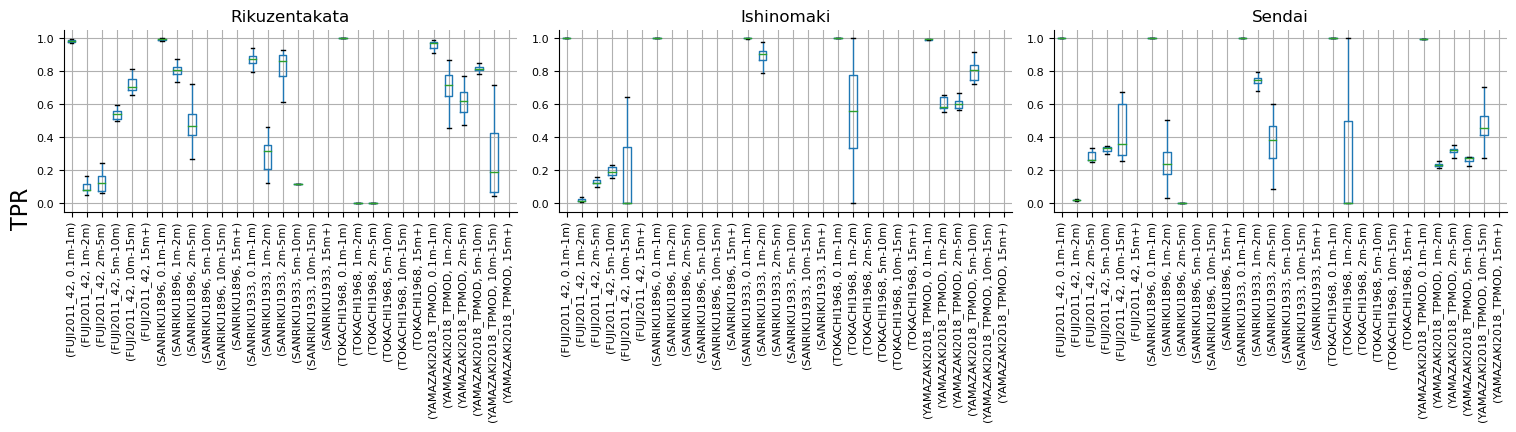

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Rikuzentakata
Site; Ishinomaki


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Sendai


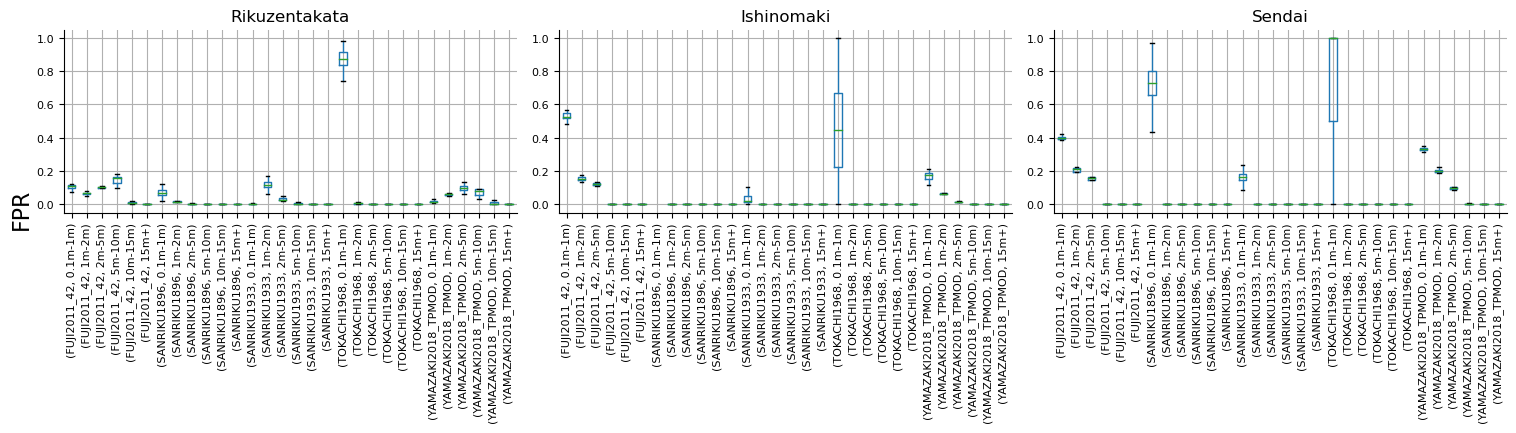

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Rikuzentakata
Site; Ishinomaki


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Sendai


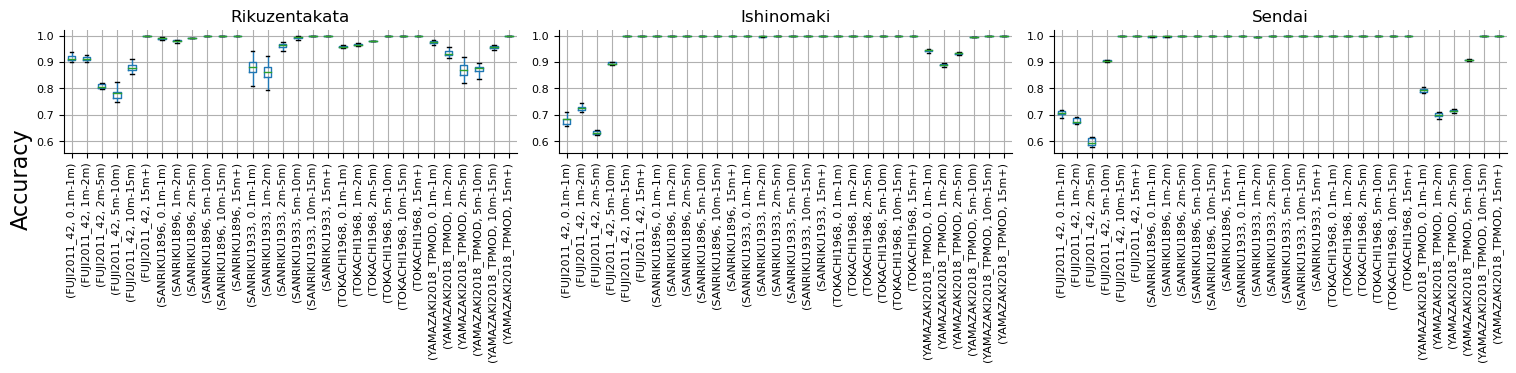

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Rikuzentakata
Site; Ishinomaki


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Sendai


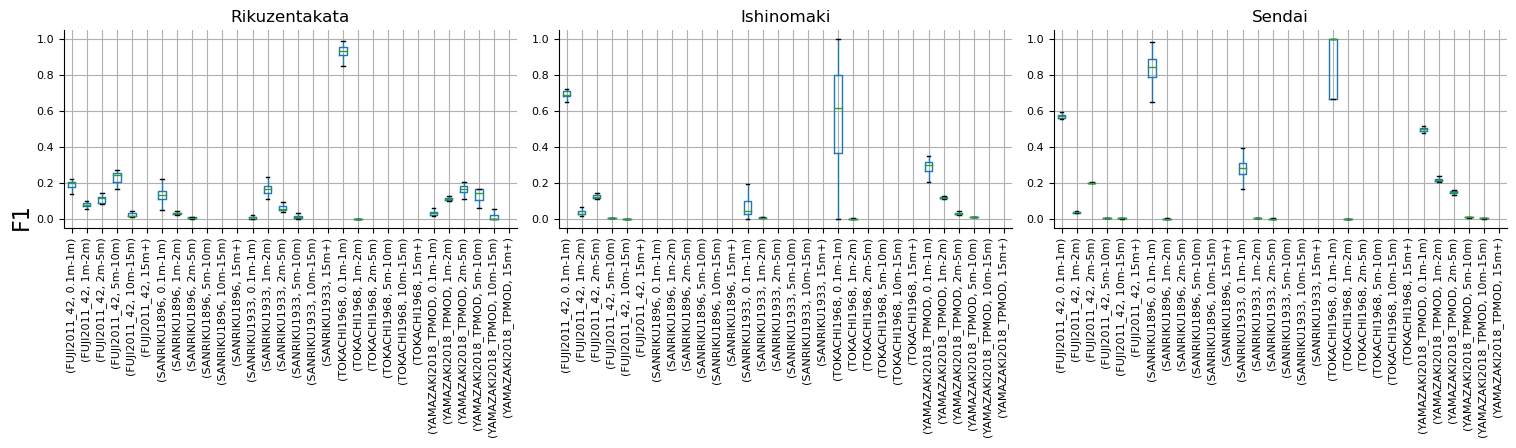

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Rikuzentakata
Site; Ishinomaki


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Site; Sendai


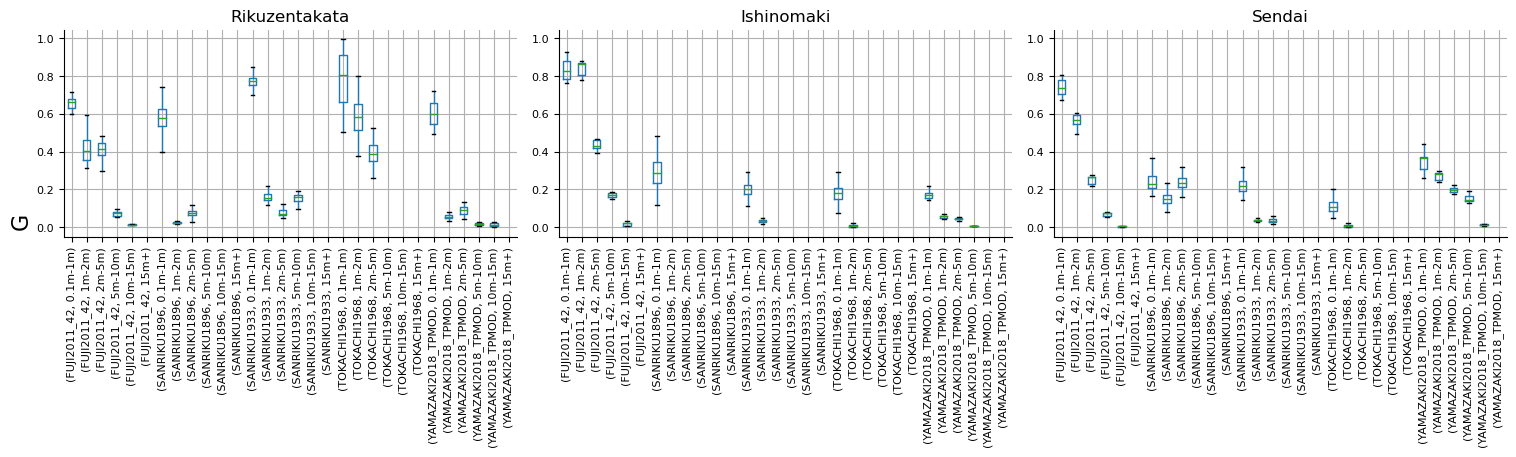

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

site_list = ['Rikuzentakata', 'Ishinomaki', 'Sendai']
#read the results and plot box plot with 15 rows for 3 region x 5 events - depth classes along x axis and accuracy along y axis
results_per_region = pd.read_csv(f'/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_depths_per_region.csv')
results_per_region['Depth'] = pd.Categorical(results_per_region['Depth'], categories=['0.1m-1m','1m-2m','2m-5m','5m-10m','10m-15m','15m+'], ordered=True)
results_per_region = results_per_region.sort_values('Depth')
results_per_region['Site'] = pd.Categorical(results_per_region['Site'], categories=['Rikuzentakata', 'Ishinomaki', 'Sendai'], ordered=True)
results_per_region = results_per_region.sort_values('Site')
results_per_region['Event'] = pd.Categorical(results_per_region['Event'], categories=['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD'], ordered=True)
results_per_region = results_per_region.sort_values('Event')

plot_type = ['TPR','FPR','Accuracy','F1','G']

for p in plot_type:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for s in range(3):
        site = site_list[s]
        print('Site; {}'.format(site))
        results_site = results_per_region[results_per_region['Site'] == site]
        # print('results_site is {}'.format(results_site))
        ax[s] = results_site.boxplot(column=p, by=['Event','Depth'], ax=ax[s], rot=90, fontsize=8,showfliers=False,)
        ax[s].spines['top'].set_visible(False)
        ax[s].spines['right'].set_visible(False)
        ax[s].spines['bottom'].set_visible(True)
        ax[s].spines['left'].set_visible(True)
        ax[s].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        ax[s].tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
        ax[s].xaxis.label.set_visible(False)
        ax[s].legend().set_visible(False)
        ax[s].set_title('{}'.format(site), fontsize=12)
    plt.suptitle('')
    plt.suptitle(f'{p}', fontsize=16,x=0,y=0.5,rotation='vertical')
    plt.tight_layout()
    plt.show()

    fig.savefig(f'/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/{p}_hist_depths_boxplot.png', dpi=300, bbox_inches='tight')




Max Test (NS)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-isfy00n0 because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


fold is 0 for site _riku_6042 
fold is 1 for site _riku_6042 
fold is 2 for site _riku_6042 
fold is 3 for site _riku_6042 
fold is 4 for site _riku_6042 


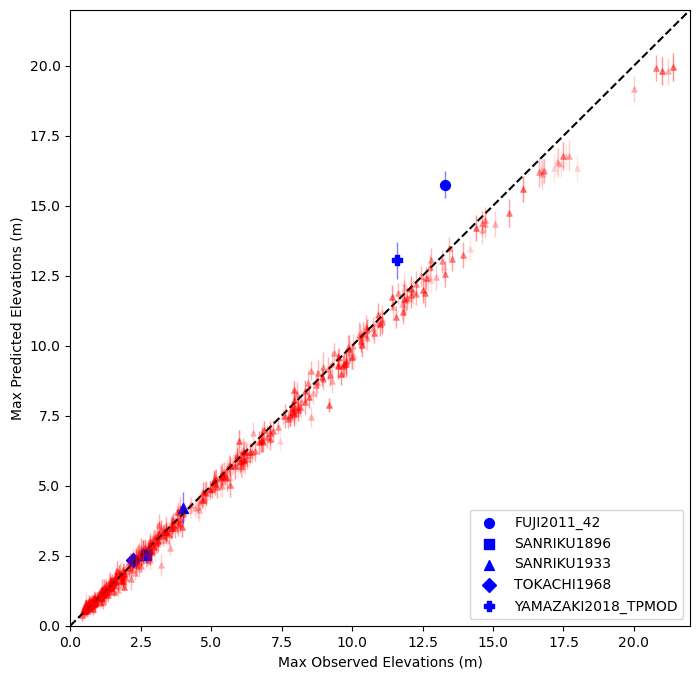

fold is 0 for site _ishi_5675 
fold is 1 for site _ishi_5675 
fold is 2 for site _ishi_5675 
fold is 3 for site _ishi_5675 
fold is 4 for site _ishi_5675 


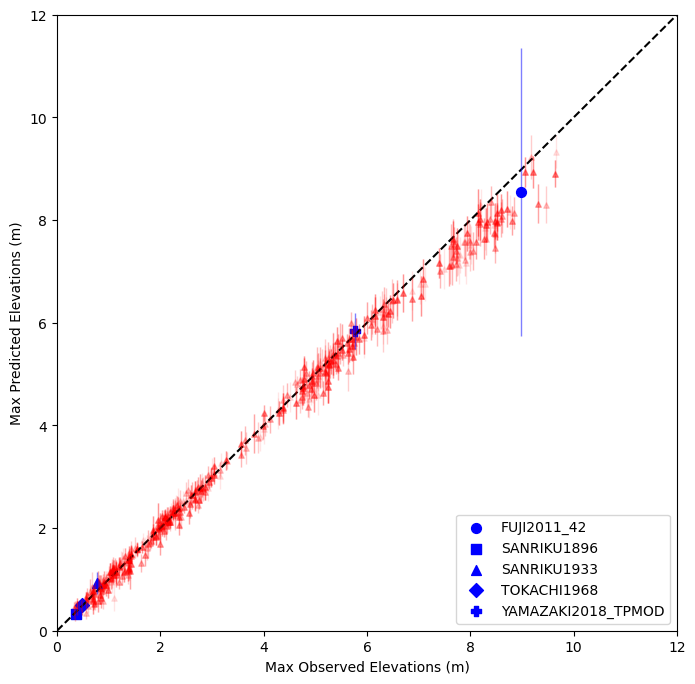

fold is 0 for site _shio_5440 
fold is 1 for site _shio_5440 
fold is 2 for site _shio_5440 
fold is 3 for site _shio_5440 
fold is 4 for site _shio_5440 


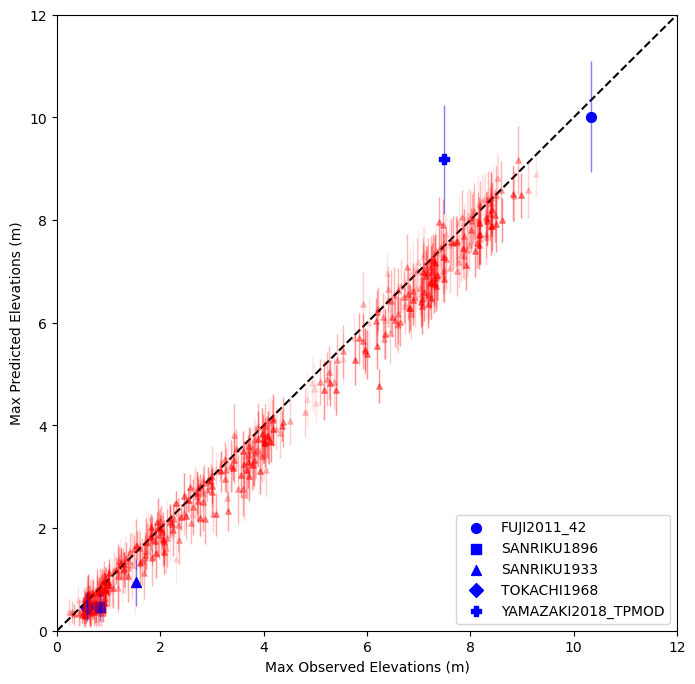

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_data(g, fold, epoch):
    idx_path = '/mnt/beegfs/nragu/tsunami/japan/Paper/TS/{}/_data/riku_test_index_k{}.txt'.format(g, fold)
    run_idx = pd.read_csv(idx_path, header=None)[0]

    runno_path = '/mnt/beegfs/nragu/tsunami/japan/Paper/TS/{}/_data/riku_test_runno_k{}.txt'.format(g, fold)
    run_no = pd.read_csv(runno_path, header=None)[0]

    predict_path = '/mnt/beegfs/nragu/tsunami/japan/Paper/TS/{}/_output/vae_riku_test_k{}_{}.npy'.format(g, fold, epoch)
    predict = np.load(predict_path)[:, -len(run_idx):, :, :].squeeze()

    data_path = '/mnt/beegfs/nragu/tsunami/japan/Paper/TS/{}/_data/riku.npy'.format(g)
    data = np.load(data_path)

    return run_no, run_idx, predict, data

def read_data_hist(g,epoch,hist_name,fold=0):   
    predict_path = '/mnt/beegfs/nragu/tsunami/japan/Paper/TS/{}/_output/vae_riku_test_{}_k{}_e{}.npy'.format(g,hist_name,fold,epoch)
    predict = np.load(predict_path)
    
    data_path = '/mnt/beegfs/nragu/tsunami/japan/Paper/TS/{}/_output/vae_riku_obs_{}.npy'.format(g,hist_name) #historical data
    data = np.load(data_path)[:, -1, :].squeeze()
    return predict, data

def scatter_plots_max_values(g, fold_list, epoch_list):
    max_values_obs = []
    max_values_pred = []
    std2_values_pred = []  
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 22], [0, 22], 'k--') 
    for fold in fold_list:
        print('fold is {} for site {} '.format(fold,g))
        run_no, run_idx, predict, data = read_data(g, fold,epoch_list[g_list.index(g)])

        for i, event_no in enumerate(run_no):
            observed_values = np.max(data[run_idx[i], -1, :]) #obs max
            predicted_maxs = np.max(predict[:, i, :], axis=1) #pred max along time axis       
            max_values = np.mean(predicted_maxs) #mean
            std2_values = 2 * np.std(predicted_maxs) #mean + 2std          

            max_values_obs.append(observed_values)
            max_values_pred.append(max_values)
            std2_values_pred.append(std2_values)
        plt.scatter(max_values_obs, max_values_pred, alpha=0.1, c='r',s=15,marker='^')
        plt.errorbar(max_values_obs, max_values_pred, yerr=std2_values_pred, fmt='none', alpha=0.1, c='r',elinewidth = 1)

    #for plotting historical data iterate over historical events then over folds
    hist_name_list = ['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD'] 
    for hist_name in hist_name_list:
        hist_max_obs = []
        hist_maxs_pred = []
        for fold in fold_list:
            predict, eve_data = read_data_hist(g,epoch_list[g_list.index(g)],hist_name,fold)  
            obs_hist_max = np.max(eve_data)
            pred_hist_maxs = np.max(predict.squeeze(), axis=1)
            
            #append all maxs to collate across folds
            hist_maxs_pred = np.append(hist_maxs_pred,pred_hist_maxs)

        hist_max_obs.append(obs_hist_max)
        hist_std2_pred = 2 * np.std(hist_maxs_pred)
        hist_max_pred = np.mean(hist_maxs_pred)

        # print(hist_max_obs, hist_max_pred, hist_std2_pred)
        plt.scatter(hist_max_obs, hist_max_pred, marker=markers[hist_name_list.index(hist_name)],label=hist_name,c='b',s=50)
        plt.errorbar(hist_max_obs, hist_max_pred, yerr=hist_std2_pred, fmt='none', c='b',elinewidth = 1, alpha=0.5)
    plt.xlabel('Max Observed Elevations (m)')
    plt.ylabel('Max Predicted Elevations (m)')
    #make the plot square
    if g == '_riku_6042':
        plt.xlim(0, 22)
        plt.ylim(0, 22)
    else:
        plt.xlim(0, 12)
        plt.ylim(0, 12)    
    plt.legend(loc='lower right')
    plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/scatter_TS_{}.png'.format(g), dpi=300)
    plt.show()

g_list = ['_riku_6042', '_ishi_5675', '_shio_5440']
epoch_list = [1500, 3000, 2000]
fold_list = [0,1,2,3,4]
markers = ['o','s','^','D','P']

for g in g_list:
    scatter_plots_max_values(g, fold_list, epoch_list)

Max Test (OS)

fold is 0 for site 1GaugeRiku 
fold is 1 for site 1GaugeRiku 
fold is 2 for site 1GaugeRiku 
fold is 3 for site 1GaugeRiku 
fold is 4 for site 1GaugeRiku 


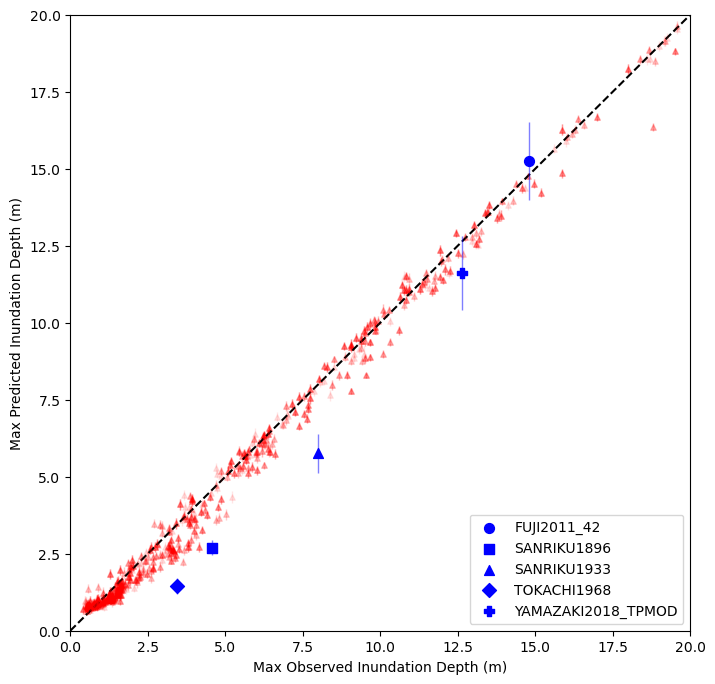

fold is 0 for site 3GaugeIshi 
fold is 1 for site 3GaugeIshi 
fold is 2 for site 3GaugeIshi 
fold is 3 for site 3GaugeIshi 
fold is 4 for site 3GaugeIshi 


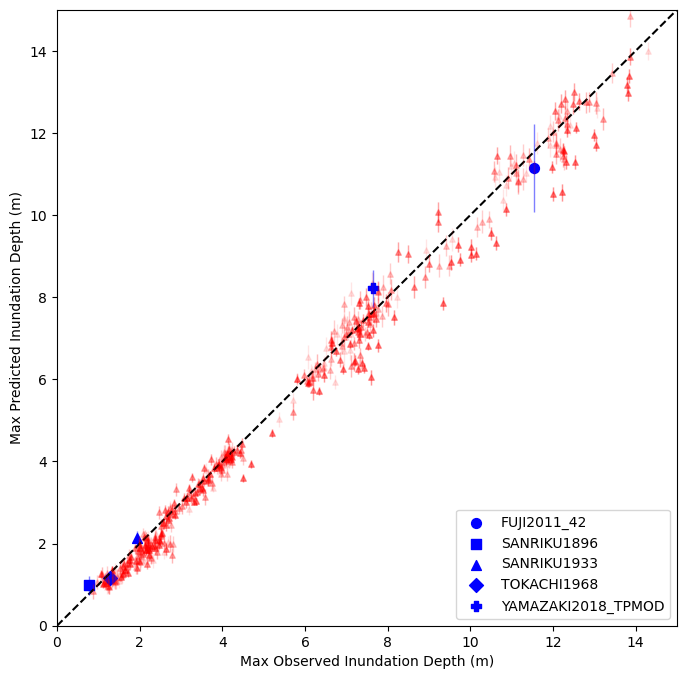

fold is 0 for site 3GaugeShio 
fold is 1 for site 3GaugeShio 
fold is 2 for site 3GaugeShio 
fold is 3 for site 3GaugeShio 
fold is 4 for site 3GaugeShio 


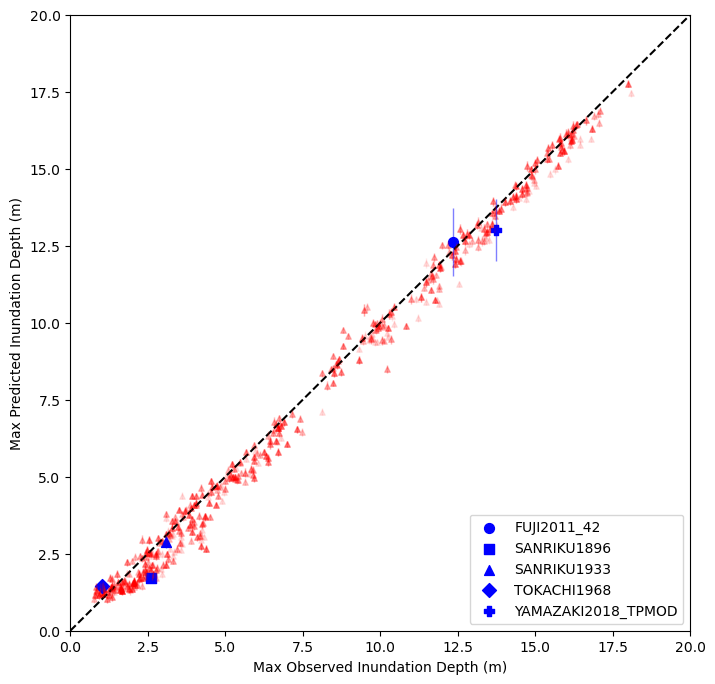

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_data(g, fold, epoch, region):
    idx_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{g}/_data/riku_test_index_k{fold}.txt'
    run_idx = pd.read_csv(idx_path, header=None)[0]

    runno_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{g}/_data/riku_test_runno_k{fold}.txt'
    run_no = pd.read_csv(runno_path, header=None)[0]

    predict_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{g}/_output/vae_riku_test_k{fold}_{epoch:04d}.npy'
    predict = np.load(predict_path)[:, -len(run_idx):, :, :].squeeze()

    data_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{g}/_data/riku_floodinputs.npy'
    data = np.load(data_path).squeeze()
  
    col_name_list = ['Lon', 'Lat', 'Ele', 'FUJI2011_42', 'NANKAI2022', 'SANRIKU1896', 'SANRIKU1933', 'TOKACHI1968', 'YAMAZAKI2018_TPMOD',
                     'SatakeMiniLowerSoft', 'SatakeMiniUpper', 'SatakeMiniUpperSoft', 'SatakeMiniLower']
         
    his_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{g}/_data/fgmax{region:04d}_hisflooded.csv'
    his_data = pd.read_csv(his_path, names=col_name_list)
    
    return run_no, run_idx, predict, data, his_data

def read_data_hist(g,epoch,hist_name,fold=0):   
    predict_path = f'/mnt/beegfs/nragu/tsunami/japan/Paper/MAP/{g}/_output/vae_riku_test_{hist_name}_k{fold}_e{epoch:04d}.npy'
    predict = np.load(predict_path)    

    return predict

def scatter_plots_max_values(g, fold_list, epoch_list):
    max_values_obs = []
    max_values_pred = []
    std2_values_pred = []  
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 32], [0, 32], 'k--') 
    for fold in fold_list:
        print('fold is {} for site {} '.format(fold,g))
        run_no, run_idx, predict, data, his_data = read_data(g, fold,epoch_list[g_list.index(g)],region_list[g_list.index(g)])
        # print(predict.shape, data.shape, his_data.shape)
        #(100, 98, 6648) (490, 6648) (6648, 13)

        for i, event_no in enumerate(run_no):
            observed_values = np.max(data[run_idx[i], :]) #obs max
            predicted_maxs = np.max(predict[:, i, :], axis=1) #pred max along time axis       
            max_values = np.mean(predicted_maxs) #mean
            std2_values = 2 * np.std(predicted_maxs) #mean + 2std 
            # print(observed_values, max_values, std2_values)         

            max_values_obs.append(observed_values)
            max_values_pred.append(max_values)
            std2_values_pred.append(std2_values)
        plt.scatter(max_values_obs, max_values_pred, alpha=0.1, c='r',s=15,marker='^')
        plt.errorbar(max_values_obs, max_values_pred, yerr=std2_values_pred, fmt='none', alpha=0.1, c='r',elinewidth = 1)

    # for plotting historical data iterate over historical events then over folds
    hist_name_list = ['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD'] 
    for hist_name in hist_name_list:
        hist_max_obs = []
        hist_maxs_pred = []
        
        #observed max
        eve_data = his_data[hist_name].squeeze()
        obs_hist_max = np.max(eve_data)
        hist_max_obs.append(obs_hist_max)
        
        #predicted max
        for fold in fold_list:
            predict = read_data_hist(g,epoch_list[g_list.index(g)],hist_name,fold)  

            pred_hist_maxs = np.max(predict.squeeze(), axis=1)          
            #append all maxs to collate across folds
            hist_maxs_pred = np.append(hist_maxs_pred,pred_hist_maxs)
        
        hist_std2_pred = 2 * np.std(hist_maxs_pred)
        hist_max_pred = np.mean(hist_maxs_pred)
        # print(hist_max_obs, hist_max_pred, hist_std2_pred)
        plt.scatter(hist_max_obs, hist_max_pred, marker=markers[hist_name_list.index(hist_name)],label=hist_name,c='b',s=50)
        plt.errorbar(hist_max_obs, hist_max_pred, yerr=hist_std2_pred, fmt='none', c='b',elinewidth = 1, alpha=0.5)
    plt.xlabel('Max Observed Inundation Depth (m)')
    plt.ylabel('Max Predicted Inundation Depth (m)')
        
    # make the plot square
    if g == '3GaugeIshi':
        plt.xlim(0, 15)
        plt.ylim(0, 15)
    else:
        plt.xlim(0, 20)
        plt.ylim(0, 20)    
    plt.legend(loc='lower right')
    plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/scatter_MAP_{}.png'.format(g), dpi=300)
    plt.show()

g_list = ['1GaugeRiku', '3GaugeIshi', '3GaugeShio']
epoch_list = [0, 0, 0]
region_list = [3,2,1]
fold_list = [0,1,2,3,4]
markers = ['o','s','^','D','P']

for g in g_list:
    scatter_plots_max_values(g, fold_list, epoch_list)


Plot combine evaluation plot

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-z786a9fo because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/tmp/ipykernel_3975197/111378464.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_ts_Rikuzentakata.csv'))
/tmp/ipykernel_3975197/111378464.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_ts_Sendai.csv'))
/tmp/ipykernel_3975197/111378464.py:8: Futur

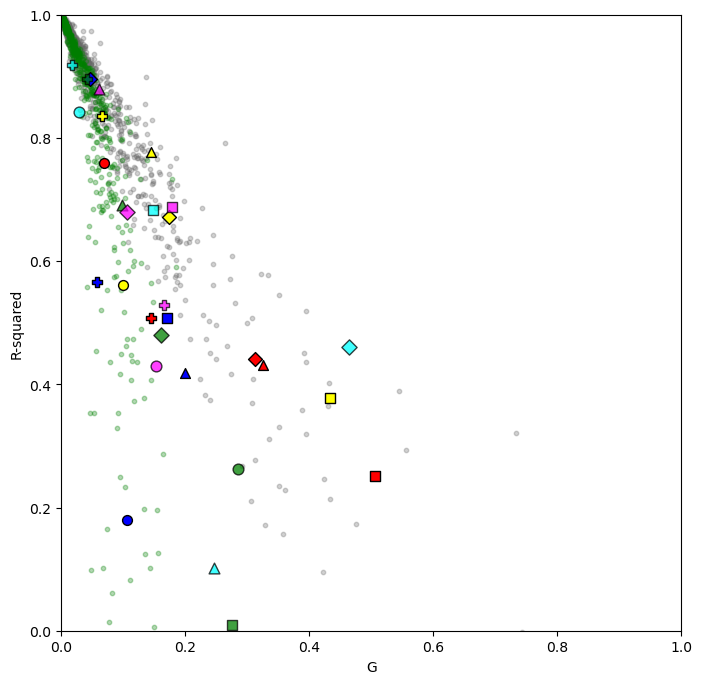

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Perf_Test = pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_ts_Ishinomaki.csv')
Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_ts_Rikuzentakata.csv'))
Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_ts_Sendai.csv'))
Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_depths_Ishinomaki.csv'))
Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_depths_Rikuzentakata.csv'))
# Perf_Test = Perf_Test.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_test_depths_Sendai.csv'))

#Calculate statistics mean by ID
Perf_Test = Perf_Test.groupby(['ID','Type','Site']).mean().reset_index()

#Historic events
Perf_Map = pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_depths_all.csv')
Perf_Map['Type'] = 'Map'
Perf_Ts = pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_ts_Rikuzentakata.csv')
Perf_Ts = Perf_Ts.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_ts_Ishinomaki.csv'))
Perf_Ts = Perf_Ts.append(pd.read_csv('/mnt/beegfs/nragu/tsunami/japan/Paper/_results/Perf_hist_ts_Sendai.csv'))
Perf_Ts['Type'] = 'Ts'
Perf = Perf_Map.append(Perf_Ts)
del Perf_Map, Perf_Ts
#set any R value less than 0 as 0
Perf['Rsquared'][Perf['Rsquared'] < 0] = 0.01

markers = ['o','s','^','D','P']
colors = [ 'blue','yellow', 'red','cyan','green','magenta',]
#Make plot with R and G
fig = plt.figure(figsize=(8, 8))

#Plot test events by type yellow(TS) and green(MAP)
plt.scatter(Perf_Test[Perf_Test['Type'] == 'TS']['G'], Perf_Test[Perf_Test['Type'] == 'TS']['R2'], marker='o', c='dimgray', label='Test (NS)', s=10, alpha=0.3 )
plt.scatter(Perf_Test[Perf_Test['Type'] == 'MAP']['G'], Perf_Test[Perf_Test['Type'] == 'MAP']['R2'], marker='o', c='green', label='Test (OS)', s=10, alpha=0.3)

for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site]
    site_data = site_data[site_data['Type'] == 'Ts']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['G'], event_data['Rsquared'], marker=markers[j], c=colors[i], label=event + '(NS-' + site +')', s=50, alpha=1, edgecolors='k')
for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site] 
    site_data = site_data[site_data['Type'] == 'Map']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['G'], event_data['Rsquared'], marker=markers[j], c=colors[i+3], label=event + '(OS-' + site +')', s=60, alpha=.75, edgecolors='k')   
plt.grid(False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('G')
plt.ylabel('R-squared')
# plt.legend(loc='upper right', fontsize=9, ncol=1, bbox_to_anchor=(1.55, 1))
plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/RG_plot.png', dpi=300)
plt.show()


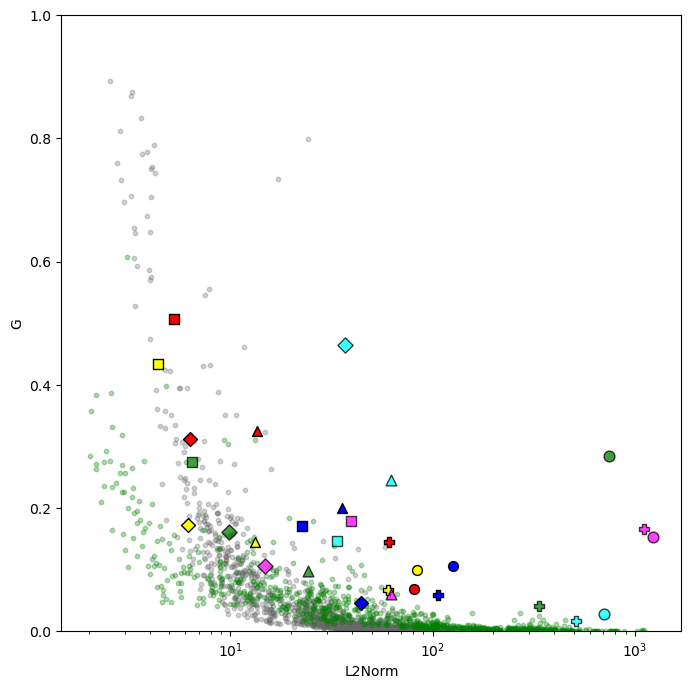

In [10]:
#plot the L2Norm vs G
fig = plt.figure(figsize=(8, 8))

#Plot test events by type yellow(TS) and green(MAP)
plt.scatter(Perf_Test[Perf_Test['Type'] == 'TS']['L2Norm'], Perf_Test[Perf_Test['Type'] == 'TS']['G'], marker='o', c='dimgray', label='Test (NS)', s=10, alpha=0.3 )
plt.scatter(Perf_Test[Perf_Test['Type'] == 'MAP']['L2Norm'], Perf_Test[Perf_Test['Type'] == 'MAP']['G'], marker='o', c='green', label='Test (OS)', s=10, alpha=0.3)

for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site]
    site_data = site_data[site_data['Type'] == 'Ts']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['L2Norm'], event_data['G'], marker=markers[j], c=colors[i], label=event + '(NS-' + site +')', s=50, alpha=1, edgecolors='k')
for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site] 
    site_data = site_data[site_data['Type'] == 'Map']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['L2Norm'], event_data['G'], marker=markers[j], c=colors[i+3], label=event + '(OS-' + site +')', s=60, alpha=0.75, edgecolors='k')
plt.grid(False)
plt.ylim(0, 1)
plt.xscale('log')
plt.xlabel('L2Norm')
plt.ylabel('G')
# plt.legend(loc='upper right', fontsize=9, ncol=1, bbox_to_anchor=(1.55, 1))
plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/L2NormG_plot.png', dpi=300)
plt.show()


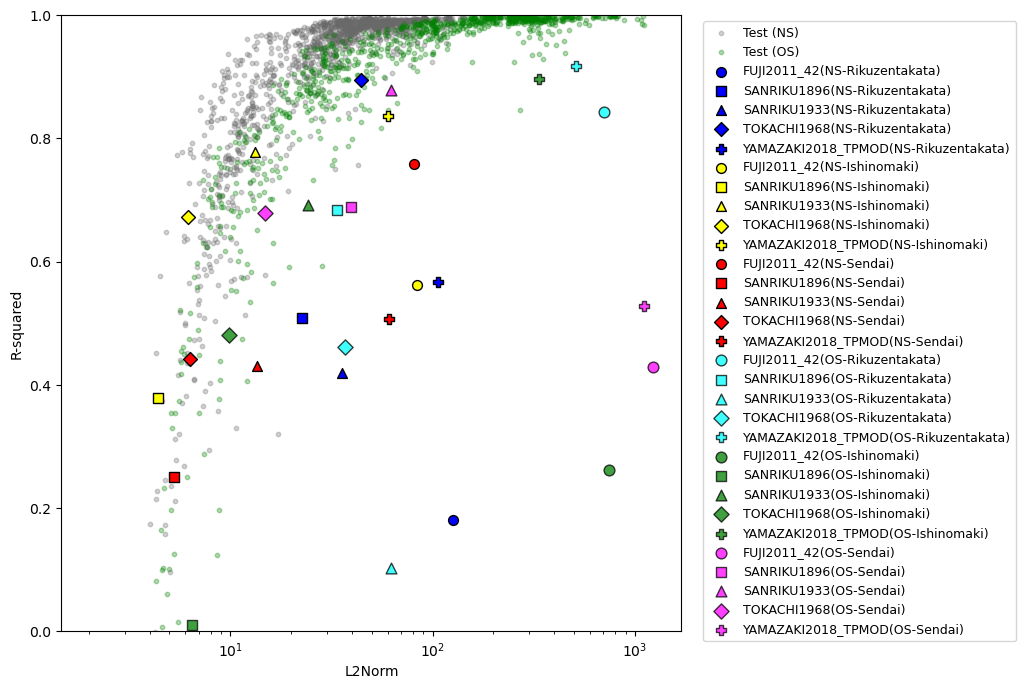

In [3]:
#plot the L2Norm vs Rsquared
fig = plt.figure(figsize=(8, 8))

#Plot test events by type yellow(TS) and green(MAP)
plt.scatter(Perf_Test[Perf_Test['Type'] == 'TS']['L2Norm'], Perf_Test[Perf_Test['Type'] == 'TS']['R2'], marker='o', c='dimgray', label='Test (NS)', s=10, alpha=0.3 )
plt.scatter(Perf_Test[Perf_Test['Type'] == 'MAP']['L2Norm'], Perf_Test[Perf_Test['Type'] == 'MAP']['R2'], marker='o', c='g', label='Test (OS)', s=10, alpha=0.3)


for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site]
    site_data = site_data[site_data['Type'] == 'Ts']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['L2Norm'], event_data['Rsquared'], marker=markers[j], c=colors[i], label=event + '(NS-' + site +')', s=50, alpha=1, edgecolors='k')
for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site] 
    site_data = site_data[site_data['Type'] == 'Map']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['L2Norm'], event_data['Rsquared'], marker=markers[j], c=colors[i+3], label=event + '(OS-' + site +')', s=60, alpha=0.75, edgecolors='k')
plt.grid(False)
plt.ylim(0, 1)

plt.xscale('log')
plt.xlabel('L2Norm')
plt.ylabel('R-squared')
plt.legend(loc='upper right', fontsize=9, ncol=1, bbox_to_anchor=(1.55, 1))
plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/L2NormR_plot.png', dpi=300)
plt.show()


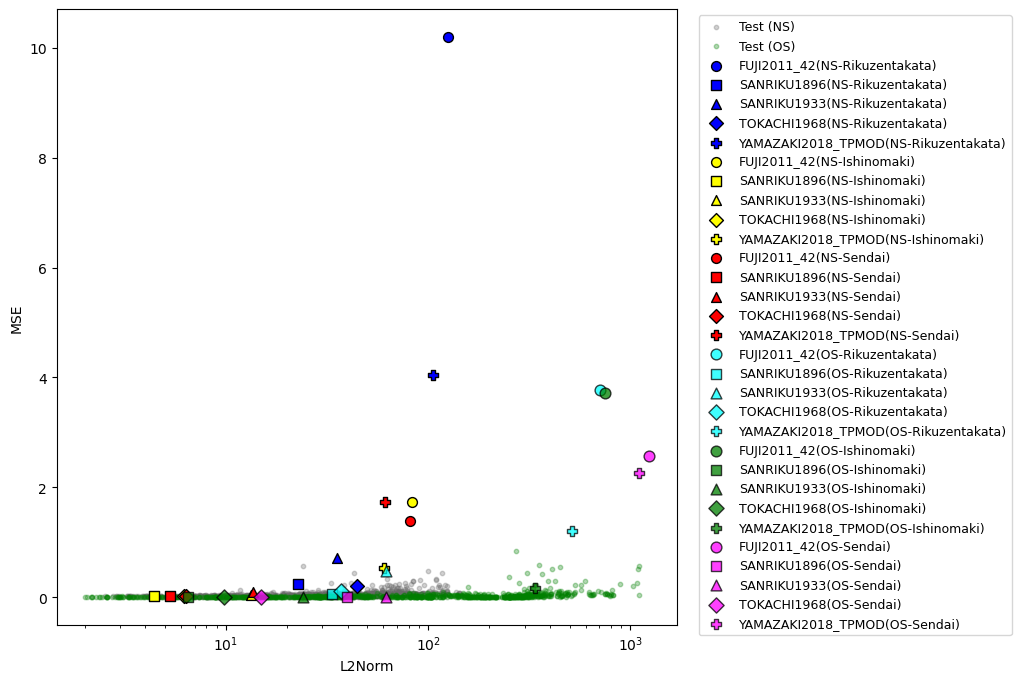

In [2]:
#plot the L2Norm vs MSE
fig = plt.figure(figsize=(8, 8))

#Plot test events by type yellow(TS) and green(MAP)
plt.scatter(Perf_Test[Perf_Test['Type'] == 'TS']['L2Norm'], Perf_Test[Perf_Test['Type'] == 'TS']['MSE'], marker='o', c='dimgray', label='Test (NS)', s=10, alpha=0.3 )
plt.scatter(Perf_Test[Perf_Test['Type'] == 'MAP']['L2Norm'], Perf_Test[Perf_Test['Type'] == 'MAP']['MSE'], marker='o', c='g', label='Test (OS)', s=10, alpha=0.3)


for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site]
    site_data = site_data[site_data['Type'] == 'Ts']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['L2Norm'], event_data['MSE'], marker=markers[j], c=colors[i], label=event + '(NS-' + site +')', s=50, alpha=1, edgecolors='k')
for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site] 
    site_data = site_data[site_data['Type'] == 'Map']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['L2Norm'], event_data['MSE'], marker=markers[j], c=colors[i+3], label=event + '(OS-' + site +')', s=60, alpha=0.75, edgecolors='k')
plt.grid(False)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('L2Norm')
plt.ylabel('MSE')
plt.legend(loc='upper right', fontsize=9, ncol=1, bbox_to_anchor=(1.55, 1))
plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/L2NormMSE_plot.png', dpi=300)
plt.show()


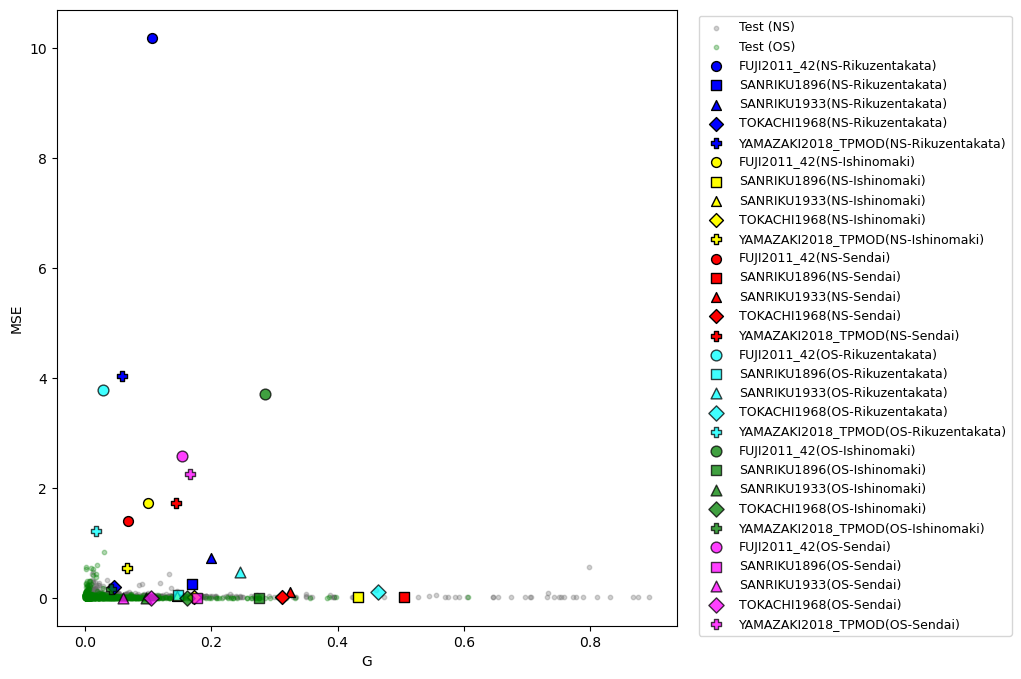

In [8]:
#plot the L2Norm vs MSE
fig = plt.figure(figsize=(8, 8))

#Plot test events by type yellow(TS) and green(MAP)
plt.scatter(Perf_Test[Perf_Test['Type'] == 'TS']['G'], Perf_Test[Perf_Test['Type'] == 'TS']['MSE'], marker='o', c='dimgray', label='Test (NS)', s=10, alpha=0.3 )
plt.scatter(Perf_Test[Perf_Test['Type'] == 'MAP']['G'], Perf_Test[Perf_Test['Type'] == 'MAP']['MSE'], marker='o', c='g', label='Test (OS)', s=10, alpha=0.3)


for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site]
    site_data = site_data[site_data['Type'] == 'Ts']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['G'], event_data['MSE'], marker=markers[j], c=colors[i], label=event + '(NS-' + site +')', s=50, alpha=1, edgecolors='k')
for i, site in enumerate(['Rikuzentakata', 'Ishinomaki', 'Sendai']):
    site_data = Perf[Perf['Site'] == site] 
    site_data = site_data[site_data['Type'] == 'Map']
    for j, event in enumerate(['FUJI2011_42','SANRIKU1896','SANRIKU1933','TOKACHI1968','YAMAZAKI2018_TPMOD']):
        event_data = site_data[site_data['Event'] == event]
        plt.scatter(event_data['G'], event_data['MSE'], marker=markers[j], c=colors[i+3], label=event + '(OS-' + site +')', s=60, alpha=0.75, edgecolors='k')
plt.grid(False)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('G')
plt.ylabel('MSE')
plt.legend(loc='upper right', fontsize=9, ncol=1, bbox_to_anchor=(1.55, 1))
plt.savefig('/mnt/beegfs/nragu/tsunami/japan/Paper/_plots/GMSE_plot.png', dpi=300)
plt.show()
